# Adrián Gayo Andrés

## Enunciado
Se propone la creación de un prototipo con varios
agentes que permita extraer publicaciones científicas de ArXiv y las publique en X.
En el ITCL se busca desarrollar una herramienta basada en un sistema de agentes cuyo
objetivo principal es permitir que los usuarios accedan a ArXiv a través de una API,
utilizando una interfaz de chat que funcione mediante lenguaje natural. Además, el sistema
debe ofrecer la posibilidad de que los usuarios publiquen, de forma sencilla y en cualquier
momento, los contenidos de una o varias investigaciones en la plataforma X. Este sistema
estará diseñado para ser semiautónomo, pero siempre bajo la supervisión directa del
usuario.


### Imports

In [18]:
# %pip install arxiv
# %pip install langchain
# %pip install langgraph
# %pip install chromadb --upgrade
# %pip install cohere
# %pip install tweepy 
# %pip install gradio
# %pip install openai
# %pip install -U langchain-community
# %pip install -U langchain_openai
# %pip install -U langchain_cohere 
# %pip install pymupdf
# %pip install -U typing-extensions

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import arxiv
import langchain
import langgraph
import tweepy
import openai 
import chromadb
import cohere
import gradio
import os
from dotenv import load_dotenv
import pandas as pd

print(langchain.__version__)


0.3.15


### ArXiV API prueba

In [2]:
# Iinicializamos el cliente de arXiv
arxiv_client = arxiv.Client()

# Query de ejemplo con la palabra "quantum."
search = arxiv.Search(
  query = "quantum",
  max_results = 10,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

# Obtenemos los resultados de la búsqueda
results = arxiv_client.results(search)

# Mostremos los resultados.
for r in arxiv_client.results(search):
  print(r.title)
  

A quantum algorithm for Khovanov homology
Mukkamala-Pereñiguez master function for even-parity perturbations of the Schwarzschild spacetime
On the distinguishability of geometrically uniform quantum states
Stochastic Calculus and Hochschild Homology
Measured Hockey-Stick Divergence and its Applications to Quantum Pufferfish Privacy
Ensemble control of n-level quantum systems with a scalar control
Boundary Curvature Scalars on Conformally Compact Manifolds
A dagger kernel category of complete orthomodular lattices
Quantum Compressive Sensing Meets Quantum Noise: A Practical Exploration
Decoherence of Schrödinger cat states in light of wave/particle duality


In [11]:
# También podemos descargar el PDF de un artículo.
paper = next(arxiv_client.results(search))
# Creamos un directorio para almacenar los PDFs en caso de que no exista.
os.makedirs("pdfs", exist_ok=True)
# Download the PDF to the PWD with a custom filename.
paper.download_pdf(filename="pdfs/" + paper.title + ".pdf")

'./pdfs/Coming full circle -- A unified framework for Kochen-Specker contextuality.pdf'

### X API prueba (tweepy)

In [3]:
# Nos autenticamos en la API de Twitter
load_dotenv()
twitter_api_key = os.getenv("TWITTER_API_KEY")
twitter_api_secret = os.getenv("TWITTER_API_SECRET")
twitter_access_token = os.getenv("TWITTER_ACCESS_TOKEN")
twitter_access_token_secret = os.getenv("TWITTER_ACCESS_TOKEN_SECRET")
bearer_token = os.getenv("BEARER_TOKEN")
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
redirect_uri = "http://127.0.0.1:5000/callback" 
print(tweepy.__version__)

# v1.0
# auth = tw.OAuth1UserHandler(twitter_api_key, twitter_api_secret, twitter_access_token, twitter_access_token_secret)
# api = tw.API(auth, wait_on_rate_limit=True)
# api.verify_credentials()
# print("Autenticación exitosa")
# api.update_status(status="Hello, world!")
# print("Tweet publicado exitosamente")

# v2.0
auth = tweepy.OAuth2UserHandler(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope="tweet.write")
print(auth)

client_X = tweepy.Client(
        consumer_key=twitter_api_key,
        consumer_secret=twitter_api_secret,
        access_token=twitter_access_token,
        access_token_secret=twitter_access_token_secret,
    )

response = client_X.create_tweet(text="Hola mundo!", user_auth=True)
print(f"Tweet publicado exitosamente: {response.data}")


4.15.0


Forbidden: 403 Forbidden
You are not allowed to create a Tweet with duplicate content.

### Prueba Chunks

In [33]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader
import re
import shutil

def limpia_caracteres(filename):
    return re.sub(r'[<>:"/\\|?*]', '', filename)
 
def prueba_chunks(papers):
    """
    Recibe una lista de papers de arXiv y almacena sus embeddings en una base de datos vectorial de ChromaDB.
    
    Parameters:
    - papers (list of dict): Lista de documentos con 'title', 'authors', 'chapters' (diccionario con capítulos y su contenido).
    """
    
    # Configurar el text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=100, separators=["\n\n", "\n", " ", "."]
    )

    pdfs = []
    for paper in papers:
        titulo = limpia_caracteres(paper.title)
        os.makedirs("pdfs", exist_ok=True)
        # Download the PDF to the PWD with a custom filename.
        paper.download_pdf(filename="pdfs/" + titulo + ".pdf")
        # Cargar el texto del paper
        pdf_loader = PyMuPDFLoader("pdfs/" + titulo + ".pdf")
        pdfs.append(pdf_loader.load())
    
    docs = []
    for pdf in pdfs:
        # juntamos todas las páginas en un solo texto, separado por dos saltos de línea. (pdf es una lista de paginas)
        full_text = "\n\n".join([page.page_content for page in pdf])
        docs.append(full_text)
        
    chunks =[]
    for full_text in docs:
        chunks.append(text_splitter.split_text(full_text))
        
    print(len(chunks[0]), chunks[0])
    # Eliminamos el contenido de la carpeta pdfs
    # shutil.rmtree("pdfs")
    # Vaciar el contenido de la carpeta pdfs
    for filename in os.listdir("pdfs"):
        file_path = os.path.join("pdfs", filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

search = arxiv.Search(
        query = "LLM",
        max_results = 3,
        sort_by = arxiv.SortCriterion.SubmittedDate
        )
       
papers = arxiv_client.results(search)
prueba_chunks(papers)


206 ['Is Long Context All You Need? Leveraging LLM’s Extended\nContext for NL2SQL\nExperiments, Analysis and Benchmark Paper\nYeounoh Chung\nGoogle\nGaurav T. Kakkar\nGoogle\nYu Gan\nGoogle\nBrenton Milne\nGoogle\nFatma Özcan\nGoogle\nABSTRACT\nLarge Language Models (LLMs) have demonstrated impressive ca-\npabilities across a range of natural language processing tasks. In\nparticular, improvements in reasoning abilities and the expansion\nof context windows have opened new avenues for leveraging these', 'of context windows have opened new avenues for leveraging these\npowerful models. NL2SQL is challenging in that the natural lan-\nguage question is inherently ambiguous, while the SQL generation\nrequires a precise understanding of complex data schema and se-\nmantics. One approach to this semantic ambiguous problem is to\nprovide more and sufficient contextual information.\nIn this work, we explore the performance and the latency trade-', 'In this work, we explore the performance and 

### Inicialización del modelo

In [2]:
from langchain_openai import ChatOpenAI
from langchain_cohere import CohereEmbeddings

# Parámetros
MAX_TOKENS = 1000
TEMPERATURE = 0.3
MODEL= "gpt-3.5-turbo"

# OpenAI API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
cohere_api_key = os.getenv("COHERE_API_KEY")

# Inicializamos el modelo de openai que vamos a utilizar con langchain.
llm = ChatOpenAI(
    model=MODEL,  
    temperature=TEMPERATURE,        
    max_tokens=MAX_TOKENS,        
    openai_api_key=openai_api_key,
    max_retries=2
)

# Realizamos una prueba de inferencia
input_text = "What is the meaning of life?"


# Inicializamos también el modelos de embeddings seleccionado.
# embeddings = OpenAIEmbeddings(    # (openai embeddings)
#     model=EMBEDDING_MODEL,  
#     openai_api_key=openai_api_key    
# )

#  alternativa para obtener embeddings
embedding_model = CohereEmbeddings(
                model="embed-english-light-v3.0",
                cohere_api_key=cohere_api_key
            )

# Iinicializamos el cliente de arXiv
arxiv_client = arxiv.Client()

# Se inicializa ChromaDB para almacenamiento vectorial persistente
chroma_client = chromadb.PersistentClient(path="./chroma_db")
vector_collection = chroma_client.get_or_create_collection("papers")

In [3]:
# Se define una función que permita monitorizar el coste de la llamada a la API de OpenAI.
from langchain.callbacks import get_openai_callback

def llamada_monitorizada(llm, texto):
    """ Función que realiza una llamada al modelo de lenguaje especificado y monitoriza el coste de la llamada.
    Args:
        llm (OpenAI): Modelo de lenguaje
        texto (str): Texto de entrada

    Returns:
        response (str): Texto de salida generado por el modelo de lenguaje
    """
    
    with get_openai_callback() as callback:
        response = llm.invoke(texto)
        
        # Detalles de uso y coste de la llamada.
        print(f"Tokens usados: {callback.total_tokens}")
        print(f"Coste de la llamada: ${callback.total_cost:.5f}")
        
        return response


In [11]:
# Prueba de llamada monitorizada.
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]

response = llamada_monitorizada(llm, messages)
print(response)
print(response.content)

Tokens usados: 40
Coste de la llamada: $0.00003
content="J'adore la programmation." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 31, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-569d1842-2412-41b3-b270-89ac98b2dda8-0' usage_metadata={'input_tokens': 31, 'output_tokens': 9, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
J'adore la programmation.


### Declaración de herramientas

#### Funciones

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


def buscar_publicaciones_arxiv(consulta: str, max_resultados: int = 3) -> object:
    """
    Busca publicaciones científicas en arXiv según una consulta del usuario.
    
    Args:
        consulta (str): El término de búsqueda para arXiv.
        max_resultados (int): Número máximo de publicaciones a devolver.

    Returns:
        PDFs de las publicaciones encontradas.
    """
    try:
        # Iinicializamos el cliente de arXiv
        arxiv_client = arxiv.Client()

        # Realizar la consulta a arXiv
        search = arxiv.Search(
            query=consulta,
            max_results=max_resultados,
            sort_by=arxiv.SortCriterion.Relevance
        )
        
        results = arxiv_client.results(search)
        
        if not results:
            return "No se encontraron publicaciones."
        
        for paper in results:
            print(paper.title)
            
        return results
          
    except Exception as e:
        return f"Error al buscar en arXiv: {str(e)}"


def store_papers_in_chroma(papers, emb_model, collection):

    # Configurar el text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500, chunk_overlap=100, separators=["\n\n", "\n", " ", ""]
    )
    
    for paper in papers:
        title = paper.get("title", "Unknown Title")
        authors = ", ".join(paper.get("authors", []))
        chapters = paper.get("chapters", {})  # Ahora 'chapters' es un diccionario con capítulos y contenido
        
        for chapter, content in chapters.items():
            # Crear el contenido del capítulo
            full_text = f"Title: {title}\nAuthors: {authors}\nChapter: {chapter}\n\n{content}"
            
            # Dividir en chunks
            chunks = text_splitter.split_text(full_text)
            
            for i, chunk in enumerate(chunks):
                chunk_id = f"{title.replace(' ', '_')}_{chapter.replace(' ', '_')}_{i}"
                embedding = emb_model.embed_query(chunk)
                
                # Almacenar en ChromaDB
                collection.add(
                    ids=[chunk_id],
                    embeddings=[embedding],
                    metadatas=[{
                        "title": title,
                        "authors": authors,
                        "chapter": chapter,
                        "chunk_index": i
                    }],
                    documents=[chunk]
                )
    
    print(f"Stored {len(papers)} papers in ChromaDB collection '{collection}'.")


def retrieve_similar_chunks(query, collection, emb_model, n_results=5):
    """
    Realiza RAG sobre la base de datos de ChromaDB buscando los n chunks más similares al texto de entrada.
    
    Parameters:
    - query (str): Texto de búsqueda.
    - collection (str): Nombre de la colección en ChromaDB.
    - n_results (int): Número de resultados más similares a devolver.
    -
    
    Returns:
    - List[dict]: Lista con los chunks más relevantes y sus metadatos.
    """
    try:
        # Generar embedding de la consulta
        query_embedding = emb_model.embed_query(query)
        
        # Buscar en ChromaDB
        results = collection.query(query_embeddings=[query_embedding], n_results=n_results)
        
        # Extraer documentos y metadatos
        retrieved_chunks = []
        for i in range(len(results["ids"][0])):
            retrieved_chunks.append({
                "chunk": results["documents"][0][i],
                "title": results["metadatas"][0][i]["title"],
                "authors": results["metadatas"][0][i]["authors"],
                "chapter": results["metadatas"][0][i]["chapter"]
            })
        
        return retrieved_chunks
    except Exception as e:
        print(f"Error al obtener información de la bbdd: {e}")


    
def publicar_en_x(texto: str) -> str:
    """
    Publica un texto en X (Twitter) utilizando la API de Tweepy.
    
    Args:
        texto (str): El texto que se desea publicar en X.
    Returns:
        str: Mensaje de éxito o error.
    """
    try:
        load_dotenv()
        twitter_api_key = os.getenv("TWITTER_API_KEY")
        twitter_api_secret = os.getenv("TWITTER_API_SECRET")
        twitter_access_token = os.getenv("TWITTER_ACCESS_TOKEN")
        twitter_access_token_secret = os.getenv("TWITTER_ACCESS_TOKEN_SECRET")
        bearer_token = os.getenv("BEARER_TOKEN")
        client_id = os.getenv("CLIENT_ID")
        client_secret = os.getenv("CLIENT_SECRET")

        # v2.0
        auth = tweepy.OAuth2UserHandler(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope="tweet.write")
        print(auth)

        client_X = tweepy.Client(
                consumer_key=twitter_api_key,
                consumer_secret=twitter_api_secret,
                access_token=twitter_access_token,
                access_token_secret=twitter_access_token_secret,
            )

        response = client_X.create_tweet(text=texto, user_auth=True)
        print(f"Tweet publicado exitosamente: {response.data}")
        
        return response.status_code #Añadir enlace al perfil de x
    
    except Exception as e:
        return f"Error al publicar el tweet: {e}"

#### Tools

In [13]:
from langchain.tools import BaseTool


class SearchOnArxivTool(BaseTool):
    """Herramienta de búsqueda de artículos científicos en arXiv."""

    name: str = "SearchOnArxivTool"
    description: str = "Searches for scientific articles on arXiv."
    
    def _run(self, consulta: str, max_resultados: int = 3) -> str:
        """Synchronous logic for executing the tool."""
        try:
            return buscar_publicaciones_arxiv(consulta, max_resultados)
        except Exception as e:
            return f"An error occurred: {str(e)}"

    async def _arun(self, consulta: str, max_resultados: int = 3) -> str:
        """Asynchronous logic for executing the tool."""
        raise NotImplementedError("This tool does not support asynchronous operations.")


class RetrieveTool(BaseTool):
    """Herramienta para recuperar chunks similares en ChromaDB."""

    name: str = "RetrieveTool"
    description: str = "Retrieves similar chunks from ChromaDB."
    
    def _run(self, query: str, n_results: int = 5) -> str:
        """Synchronous logic for executing the tool."""
        try:
            return retrieve_similar_chunks(query, vector_collection, embedding_model, n_results)
        except Exception as e:
            return f"An error occurred: {str(e)}"

    async def _arun(self, query: str, collection: str, emb_model: str, n_results: int = 5) -> str:
        """Asynchronous logic for executing the tool."""
        raise NotImplementedError("This tool does not support asynchronous operations.")


class TwitterPostTool(BaseTool):
    """Herramienta para publicar texto en X(Twitter)."""
    
    name: str = "TwitterPostTool"
    description: str = (
        "Posts a message on X(Twitter). "
        "Use this to share a message given a in your X account."
    )
    
    def _run(self, texto: str) -> str:
        """Synchronous logic for executing the tool."""
        try:
            return publicar_en_x(texto)
        except Exception as e:
            return f"An error occurred: {str(e)}"
    
    async def _arun(self, texto: str) -> str:
        """Asynchronous logic for executing the tool."""
        raise NotImplementedError("This tool does not support asynchronous operations.")

In [14]:
# Diccionario con las herramientas disponibles.
herramientas_disponibles = {
    "arxiv_search": SearchOnArxivTool(),
    "rag": RetrieveTool(),
    "twitter_publisher": TwitterPostTool()
}

### Clases de los nodos

#### Clases

In [15]:
from typing_extensions import TypedDict
from typing import Literal, Sequence
from langchain.schema import BaseMessage, HumanMessage

class Router(TypedDict):
    """Clase para el nodo que enruta las solicitudes a las herramientas correspondientes."""
    
    next: Literal["SearchOnArxivTool", "RetrivalDocumentInformation" "TwitterPostTool", "FINISH"]
    

class AgentState(TypedDict):
    """Clase para el estado del agente."""
    
    messages: Sequence[BaseMessage]

#### Funciones

In [20]:
from typing_extensions import TypedDict
from typing import Literal, Sequence
from langchain.schema import BaseMessage, HumanMessage
from langchain.tools import Tool
from langgraph.graph import StateGraph, MessagesState, END
from langgraph.types import Command


# Función para crear agentes genérica (Subgrafo que solo permite el uso de una herramienta por agente).
def create_agent(llm, tool):
    llm_with_tools = llm.bind_tools([tool])
    def agent_function(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", agent_function)
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()

system_prompt = ""

# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["arxiv_search", "rag", "twitter_publisher", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)

### Grafo Multiagente

In [24]:
from langgraph.graph import StateGraph, MessagesState, START, END

# Declaración de los elementos del grafo.
# Agentes de las herramientas.
search_on_arxiv_agent = create_agent(llm, herramientas_disponibles["arxiv_search"])
retrival_document_information_agent= create_agent(llm, herramientas_disponibles["rag"])
twitter_post_agent = create_agent(llm, herramientas_disponibles["twitter_publisher"])

# Nodos de las herramientas.
def search_on_arxiv_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = search_on_arxiv_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="SearchOnArxivTool")
            ]
        },
        goto="supervisor"
    )

def retrival_document_information_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = retrival_document_information_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="RetrivalDocumentInformation")
            ]
        },
        goto="supervisor"
    )

def twitter_post_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = twitter_post_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="TwitterPostTool")
            ]
        },
        goto="supervisor"
    )


# Generación del grafo.
builder = StateGraph(MessagesState)

# Añadimos los nodos de las herramientas al grafo.
builder.add_edge(START,"supervisor")

builder.add_node("supervisor", supervisor_node)
builder.add_node("arxiv_search", search_on_arxiv_node)
builder.add_node("rag", retrival_document_information_node)
builder.add_node("twitter_publisher", twitter_post_node)

graph = builder.compile()


### Visualización del Grafo

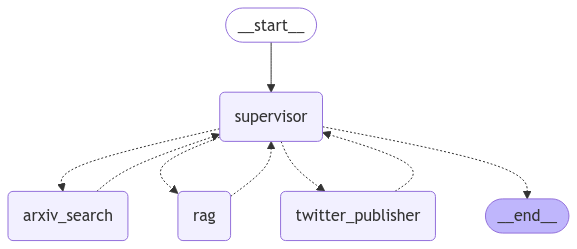

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al mostrar la imagen: {str(e)}")

### Generación de base de datos vectorial

In [12]:
# Se incializa el cliente y se crea una BBDD (collection)
chroma_client = chromadb.Client()

# Crea la colección
collection = chroma_client.create_collection(name="arxiv")

# Añade documentos a la colección
collection.add(
    documents=["ejemplo número 1", "ejemplo número 2", "ejemplo número 3"],
    metadatas=[{"source": "arxiv"}, {"source": "arxiv"}, {"source": "arxiv"}],
    ids=["1", "2", "3"]
)

### Front 

In [16]:

def yes_man(message, history):
    if message.endswith("?"):
        return "Yes"
    else:
        return "Ask me anything!"
    
def user_interface(user_input, history=[]):
    state= {"messages": history + [HumanMessage(content=user_input)]}
    results = graph.invoke(state)
    response = results["messages"][-1].content
    history.append((user_input, response))
    return response, history
   

demo = gradio.ChatInterface(
    fn=yes_man,
    title="MULTIAGENTE ARXIV RAG",
    description="Say hello to someone!",
)

demo.launch()


c:\Users\adria\anaconda3\Lib\site-packages\gradio\components\chatbot.py:279: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
